In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import pysam
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from utils.util_lift_over import liftover

if not os.getcwd().endswith('cfdna_snv_benchmark'):
    os.chdir('../')
print('Current working directory: {}'.format(os.getcwd()))

Current working directory: /Users/hanae/Repositories/cfdna_snv_benchmark


In [3]:
target = 'coding'
if target == 'coding':
    cosmic_pd = pd.read_csv(os.path.join('data', 'extdata', 'CosmicMutantExport.tsv'), encoding='ISO-8859-1', sep='\t', memory_map=True)
else: # target == 'noncoding'
    cosmic_pd = pd.read_csv(os.path.join('data', 'extdata', 'CosmicNCV.tsv'), encoding='ISO-8859-1', sep='\t', memory_map=True)

print(cosmic_pd.shape)

(48500634, 39)


In [4]:
cosmic_pd.columns

Index(['Gene name', 'Accession Number', 'Gene CDS length', 'HGNC ID',
       'Sample name', 'ID_sample', 'ID_tumour', 'Primary site',
       'Site subtype 1', 'Site subtype 2', 'Site subtype 3',
       'Primary histology', 'Histology subtype 1', 'Histology subtype 2',
       'Histology subtype 3', 'Genome-wide screen', 'GENOMIC_MUTATION_ID',
       'LEGACY_MUTATION_ID', 'MUTATION_ID', 'Mutation CDS', 'Mutation AA',
       'Mutation Description', 'Mutation zygosity', 'LOH', 'GRCh',
       'Mutation genome position', 'Mutation strand', 'Resistance Mutation',
       'FATHMM prediction', 'FATHMM score', 'Mutation somatic status',
       'Pubmed_PMID', 'ID_STUDY', 'Sample Type', 'Tumour origin', 'Age',
       'HGVSP', 'HGVSC', 'HGVSG'],
      dtype='object')

## Columns for coding file
['Gene name', 'Accession Number', 'Gene CDS length', 'HGNC ID',
'Sample name', 'ID_sample', 'ID_tumour', 'Primary site',
'Site subtype 1', 'Site subtype 2', 'Site subtype 3',
'Primary histology', 'Histology subtype 1', 'Histology subtype 2',
'Histology subtype 3', 'Genome-wide screen', 'GENOMIC_MUTATION_ID',
'LEGACY_MUTATION_ID', 'MUTATION_ID', 'Mutation CDS', 'Mutation AA',
'Mutation Description', 'Mutation zygosity', 'LOH', 'GRCh',
'Mutation genome position', 'Mutation strand', 'Resistance Mutation',
'FATHMM prediction', 'FATHMM score', 'Mutation somatic status',
'Pubmed_PMID', 'ID_STUDY', 'Sample Type', 'Tumour origin', 'Age',
'HGVSP', 'HGVSC', 'HGVSG']
## Columns for noncoding file


## Primary sites
['breast' 'haematopoietic_and_lymphoid_tissue' 'lung' 'liver'
 'endometrium' 'upper_aerodigestive_tract' 'large_intestine' 'skin'
 'kidney' 'soft_tissue' 'ovary' 'central_nervous_system' 'biliary_tract'
 'stomach' 'oesophagus' 'prostate' 'urinary_tract' 'bone'
 'autonomic_ganglia' 'penis' 'uterine_adnexa' 'cervix' 'pancreas' 'NS'
 'testis' 'thyroid' 'pleura' 'placenta' 'meninges' 'small_intestine'
 'genital_tract' 'adrenal_gland' 'salivary_gland' 'thymus' 'peritoneum'
 'eye' 'parathyroid' 'pituitary'
 'gastrointestinal_tract_(site_indeterminate)'
 'female_genital_tract_(site_indeterminate)' 'vulva' 'fallopian_tube'
 'vagina' 'paratesticular_tissues' 'perineum' 'retroperitoneum'
 'pericardium' 'mediastinum' 'female_genitourinary_system']

In [32]:
cancer_type = 'CRC'
chrom = '23'

In [33]:
# cancer type selection
if cancer_type == 'CRC':
    if target == 'coding':
        cosmic_muts = cosmic_pd[(cosmic_pd['Primary site'] == 'large_intestine') & (cosmic_pd['Site subtype 1'] == 'colon') & (cosmic_pd['Tumour origin'] == 'primary')]
    else: # target == 'noncoding'
        cosmic_muts = cosmic_pd[(cosmic_pd['Primary site'] == 'large_intestine') & (cosmic_pd['Site subtype 1'] == 'colon')]

else:
    print('NEED TO INCLUDE THIS CANCER TYPE')
print(cosmic_muts.shape)

(269084, 39)


In [34]:
# remove nan positions in GRCh37
cosmic_muts = cosmic_muts[~cosmic_muts["GRCh"].isna()]
print(cosmic_muts.shape)

(268179, 39)


In [35]:
# annotate mutation type
cosmic_muts['type'] = np.nan
if target == 'coding':
    print(cosmic_muts['Mutation Description'].unique()) # SNV or INDEL
    cosmic_muts['type'][cosmic_muts['Mutation Description'].str.contains('Substitution') == True] = 'SNV'
    cosmic_muts['type'][cosmic_muts['Mutation Description'].str.contains('Insertion') == True] = 'INS'
    cosmic_muts['type'][cosmic_muts['Mutation Description'].str.contains('Deletion') == True] = 'DEL'
    cosmic_muts.dropna(subset=['type'], inplace=True)
else: # target == 'noncoding'
    cosmic_muts['type'][cosmic_muts['MUT_SEQ'].str.len()-cosmic_muts['WT_SEQ'].str.len() == 0] = 'SNV'
    cosmic_muts['type'][cosmic_muts['MUT_SEQ'].str.len()-cosmic_muts['WT_SEQ'].str.len() > 0] = 'INS'
    cosmic_muts['type'][cosmic_muts['MUT_SEQ'].str.len()-cosmic_muts['WT_SEQ'].str.len() < 0] = 'DEL'
    cosmic_muts = cosmic_muts[~cosmic_muts['type'].isna()]
print(cosmic_muts.shape)
cosmic_muts.head()

['Substitution - Missense' 'Unknown' 'Substitution - coding silent'
 'Substitution - Nonsense' 'Nonstop extension' 'Deletion - Frameshift'
 'Insertion - Frameshift' 'Insertion - In frame' 'Deletion - In frame' nan
 'Complex - frameshift']


/Users/hanae/opt/anaconda3/envs/default/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/hanae/opt/anaconda3/envs/default/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/hanae/opt/anaconda3/envs/default/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


(227290, 40)


,Gene name,Accession Number,Gene CDS length,HGNC ID,Sample name,ID_sample,ID_tumour,Primary site,Site subtype 1,Site subtype 2,...,Mutation somatic status,Pubmed_PMID,ID_STUDY,Sample Type,Tumour origin,Age,HGVSP,HGVSC,HGVSG,type
52,ADAMTS13_ENST00000371910,ENST00000371910.1,672,1366.0,587376,1766805,1671125,large_intestine,colon,NS,...,Reported in another cancer sample as somatic,22895193.0,NaN,surgery fresh/frozen,primary,NaN,ENSP00000360978.1:p.Ser29Tyr,ENST00000371910.1:c.86C>A,9:g.136321320C>A,SNV
128,OPRL1,ENST00000349451.3,1113,8155.0,587336,1766786,1671106,large_intestine,colon,NS,...,Variant of unknown origin,22895193.0,NaN,surgery fresh/frozen,primary,NaN,ENSP00000336764.3:p.Ala178Thr,ENST00000349451.3:c.532G>A,20:g.62729453G>A,SNV
444,PGBD1_ENST00000259883,ENST00000259883.3,2430,19398.0,587234,1766754,1671074,large_intestine,colon,NS,...,Variant of unknown origin,22895193.0,NaN,surgery fresh/frozen,primary,NaN,ENSP00000259883.3:p.Lys634Arg,ENST00000259883.3:c.1901A>G,6:g.28269532A>G,SNV
459,PGBD1_ENST00000259883,ENST00000259883.3,2430,19398.0,587376,1766805,1671125,large_intestine,colon,NS,...,Variant of unknown origin,22895193.0,NaN,surgery fresh/frozen,primary,NaN,ENSP00000259883.3:p.Lys569Thr,ENST00000259883.3:c.1706A>C,6:g.28269337A>C,SNV
670,LMNTD2,ENST00000329451.3,1905,28561.0,587316,1766779,1671099,large_intestine,colon,NS,...,Confirmed somatic variant,22895193.0,NaN,surgery fresh/frozen,primary,NaN,ENSP00000331167.3:p.Arg241Gln,ENST00000329451.3:c.722G>A,11:g.557089C>T,SNV


In [36]:
# encode mutation position
if target == 'coding':
    mutposname = 'Mutation genome position'
else: # target == 'noncoding'
    mutposname = 'genome position'
cosmic_muts['chrom'] = cosmic_muts[mutposname].str.split(':').str[0]
cosmic_muts['chrom'][cosmic_muts['chrom'] == 23] = 'X'
cosmic_muts['chrom'][cosmic_muts['chrom'] == 24] = 'Y'
cosmic_muts['startpos'] = cosmic_muts[mutposname].str.split(':').str[1].str.split('-').str[0]
cosmic_muts['endpos'] = cosmic_muts[mutposname].str.split(':').str[1].str.split('-').str[1]
cosmic_muts['chrom_pos'] = cosmic_muts['chrom'] + '_' + cosmic_muts['startpos'] + '_' + cosmic_muts['endpos']
cosmic_muts['startpos'] = cosmic_muts['startpos'].astype(int)
cosmic_muts['endpos'] = cosmic_muts['endpos'].astype(int)
cosmic_muts.dropna(subset=['chrom', 'startpos', 'endpos'], inplace=True)

/Users/hanae/opt/anaconda3/envs/default/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/hanae/opt/anaconda3/envs/default/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


1.0 3.1974846660289233 2.0 4.0


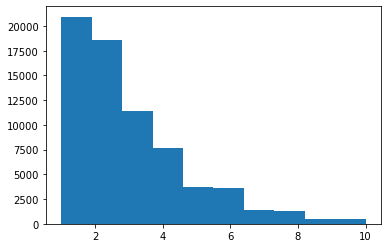

In [37]:
# get occurences
occurences = cosmic_muts[mutposname].value_counts().values
plt.hist(occurences[occurences <= 10])
print(np.quantile(occurences, 0.25), np.mean(occurences), np.median(occurences), np.quantile(occurences, 0.75))

In [38]:
# set threshold = at least 5 patients
threshold = 5
occ = cosmic_muts['chrom_pos'].value_counts() 
common_muts_occ = occ[occ >= threshold]
common_muts = list(common_muts_occ.index)
print(len(common_muts))

12472


In [39]:
# select only single chromosome
cosmic_muts = cosmic_muts[cosmic_muts['chrom_pos'].isin(common_muts)]
print(cosmic_muts.shape)
cosmic_muts['chrom'].value_counts()

(104192, 44)


12    11581
2     11033
17    11031
1      7709
3      5616
6      5544
19     5464
5      5386
11     4765
9      3994
7      3930
10     3753
4      3490
16     2968
8      2963
23     2709
20     2430
14     2217
15     2124
18     1783
22     1554
21     1109
13     1032
24        7
Name: chrom, dtype: int64

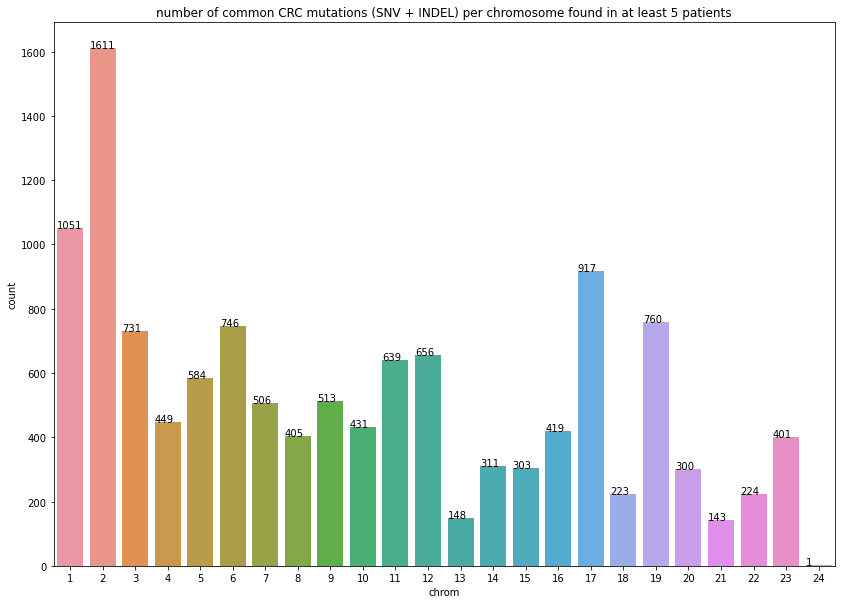

In [40]:
plt.figure(figsize=(14,10))
ax = sns.countplot(x='chrom', data=cosmic_muts[['chrom', 'startpos', 'endpos', 'chrom_pos']].drop_duplicates(), order=np.arange(1,25).astype(str))
plt.title('number of common {} mutations (SNV + INDEL) per chromosome found in at least {} patients'.format(cancer_type, threshold))
for p in ax.patches:
        ax.annotate('{}'.format(p.get_height()), (p.get_x(), p.get_height()))

In [41]:
cosmic_muts_chr = cosmic_muts[cosmic_muts['chrom'] == chrom]
print(cosmic_muts_chr.shape)

(2709, 44)


In [44]:
if target == 'coding':
    # info about nomenclature http://varnomen.hgvs.org/recommendations/DNA/
    cosmic_muts_chr['ref'] = np.nan
    cosmic_muts_chr['alt'] = np.nan
    cosmic_muts_chr['ref'][cosmic_muts_chr['type'] == 'SNV'] = cosmic_muts_chr[cosmic_muts_chr['type'] == 'SNV']['Mutation CDS'].str.split('>').str[0].str[-1] 
    cosmic_muts_chr['alt'][cosmic_muts_chr['type'] == 'SNV'] = cosmic_muts_chr[cosmic_muts_chr['type'] == 'SNV']['Mutation CDS'].str.split('>').str[1]
    cosmic_muts_chr['alt'][cosmic_muts_chr['type'] == 'INS'] = cosmic_muts_chr[cosmic_muts_chr['type'] == 'INS']['Mutation CDS'].str.split('ins').str[1] 
    for ri, row in cosmic_muts_chr.iterrows():
        if (row['type'] == 'INS') and (row['Mutation CDS'].endswith('dup')):
            chromrow, startpos, endpos = row['chrom_pos'].split('_')
            if chromrow.startswith('chr'):
                chromrow = chromrow[3:]
            if chromrow == '23':
                chromrow = 'X'
            elif chromrow == '24':
                chromrow = 'Y' 
            startpos, endpos = int(startpos), int(endpos)
            fasta = pysam.FastaFile(os.path.join('data', 'GRCh37', 'GRCh37.fa'))
            ref_seq = fasta.fetch(chromrow, startpos-1, startpos)
            fasta.close()
            cosmic_muts_chr.at[ri, 'ref'] = ref_seq
            cosmic_muts_chr.at[ri, 'alt'] = ref_seq
    # needs shift in deletions for bamsurgeon to indicate length of deletion
    cosmic_muts_chr.loc[cosmic_muts_chr['type'] == 'DEL', 'endpos'] += 1 #cosmic_muts_chr[cosmic_muts_chr['type'] == 'DEL', 'endpos'] + 1
else: # target noncoding
    cosmic_muts_chr['ref'] = cosmic_muts_chr['WT_SEQ']
    cosmic_muts_chr['alt'] = cosmic_muts_chr['MUT_SEQ']
cosmic_muts_chr.head()

/Users/hanae/opt/anaconda3/envs/default/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/hanae/opt/anaconda3/envs/default/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/hanae/opt/anaconda3/envs/default/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:

,Gene name,Accession Number,Gene CDS length,HGNC ID,Sample name,ID_sample,ID_tumour,Primary site,Site subtype 1,Site subtype 2,...,HGVSP,HGVSC,HGVSG,type,chrom,startpos,endpos,chrom_pos,ref,alt
29385,TCEAL4_ENST00000494801,ENST00000494801.1,648,26121.0,MSU3-a,2809972,2666634,large_intestine,colon,transverse,...,ENSP00000427494.1:p.Lys46Asn,ENST00000494801.1:c.138G>T,X:g.102841741G>T,SNV,23,102841741,102841741,23_102841741_102841741,G,T
30297,TCEAL4_ENST00000494801,ENST00000494801.1,648,26121.0,587376,1766805,1671125,large_intestine,colon,NS,...,ENSP00000427494.1:p.Leu59Val,ENST00000494801.1:c.175T>G,X:g.102841778T>G,SNV,23,102841778,102841778,23_102841778_102841778,T,G
31197,TCEAL4_ENST00000494801,ENST00000494801.1,648,26121.0,MSU3-c,2809980,2666642,large_intestine,colon,transverse,...,ENSP00000427494.1:p.Lys46Asn,ENST00000494801.1:c.138G>T,X:g.102841741G>T,SNV,23,102841741,102841741,23_102841741_102841741,G,T
33649,TBL1X_ENST00000424279,ENST00000424279.1,1581,11585.0,587230,1766752,1671072,large_intestine,colon,NS,...,ENSP00000394097.1:p.His308Tyr,ENST00000424279.1:c.922C>T,X:g.9665430C>T,SNV,23,9665430,9665430,23_9665430_9665430,C,T
49472,TBL1X_ENST00000424279,ENST00000424279.1,1581,11585.0,587278,1766767,1671087,large_intestine,colon,NS,...,ENSP00000394097.1:p.Val460Ile,ENST00000424279.1:c.1378G>A,X:g.9679742G>A,SNV,23,9679742,9679742,23_9679742_9679742,G,A


In [45]:
cosmic_bed_chr = cosmic_muts_chr[['chrom', 'startpos', 'endpos', 'alt', 'type']].reset_index(drop=True)
cosmic_bed_chr.drop_duplicates(inplace=True, ignore_index=True)
print(cosmic_bed_chr.shape)
print(cosmic_bed_chr[cosmic_bed_chr['type'] == 'INS'].head())
print(cosmic_bed_chr[cosmic_bed_chr['type'] == 'DEL'].head())
cosmic_bed_chr.head()

(402, 5)
    chrom   startpos     endpos alt type
28     23   66765227   66765228   A  INS
39     23  144904124  144904125   C  INS
77     23  151092732  151092733   A  INS
300    23   37312618   37312619   C  INS
322    23  122551316  122551317   T  INS
    chrom   startpos     endpos  alt type
30     23   66765222   66765228  NaN  DEL
140    23   70360635   70360647  NaN  DEL
153    23  100880973  100880974  NaN  DEL
184    23  135488070  135488071  NaN  DEL
203    23  102003973  102003974  NaN  DEL


,chrom,startpos,endpos,alt,type
0,23,102841741,102841741,T,SNV
1,23,102841778,102841778,G,SNV
2,23,9665430,9665430,T,SNV
3,23,9679742,9679742,A,SNV
4,23,9656190,9656190,T,SNV


In [46]:
# check for errors
# SNV
print(sum(cosmic_bed_chr[cosmic_bed_chr['type'] == 'SNV']['endpos'] != cosmic_bed_chr[cosmic_bed_chr['type'] == 'SNV']['startpos']))
# INS
print(sum(cosmic_bed_chr[cosmic_bed_chr['type'] == 'INS']['endpos'] - cosmic_bed_chr[cosmic_bed_chr['type'] == 'INS']['startpos'] != cosmic_bed_chr[cosmic_bed_chr['type'] == 'INS']['alt'].str.len()))
print(sum(cosmic_bed_chr[cosmic_bed_chr['type'] == 'INS']['endpos'] - cosmic_bed_chr[cosmic_bed_chr['type'] == 'INS']['startpos'] <= 0))
# DEL
print(sum(cosmic_bed_chr[cosmic_bed_chr['type'] == 'DEL']['startpos'] - cosmic_bed_chr[cosmic_bed_chr['type'] == 'DEL']['endpos'] >= 0))

0
0
0
0


23    376
Name: chrom, dtype: int64
23    26
Name: chrom, dtype: int64


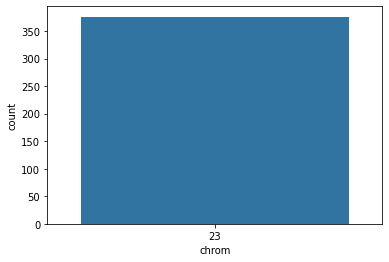

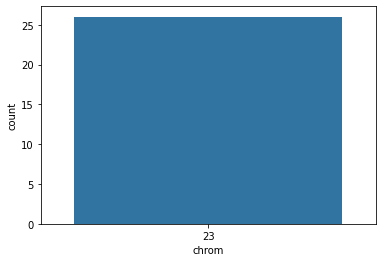

In [47]:
sns.countplot(x='chrom', data=cosmic_bed_chr[cosmic_bed_chr['type'] == 'SNV'])
print(cosmic_bed_chr[cosmic_bed_chr['type'] == 'SNV']['chrom'].value_counts().sort_index())
plt.figure()
sns.countplot(x='chrom', data=cosmic_bed_chr[(cosmic_bed_chr['type'] == 'INS') | (cosmic_bed_chr['type'] == 'DEL')])
print(cosmic_bed_chr[(cosmic_bed_chr['type'] == 'INS') | (cosmic_bed_chr['type'] == 'DEL')]['chrom'].value_counts().sort_index())

# Save for SNV and INDEL bedfile for bamsurgeon

In [48]:
### /!\ 1-based index for SNV bamsurgeon
cosmic_bed_chr_snv = cosmic_bed_chr[cosmic_bed_chr['type'] == 'SNV'].drop('type', axis=1)
cosmic_bed_chr_snv.insert(loc = 3, column = 'vaf', value = 1)  # Insert default VAF column
cosmic_bed_chr_snv

,chrom,startpos,endpos,vaf,alt
0,23,102841741,102841741,1,T
1,23,102841778,102841778,1,G
2,23,9665430,9665430,1,T
3,23,9679742,9679742,1,A
4,23,9656190,9656190,1,T
...,...,...,...,...,...
397,23,39921639,39921639,1,C
398,23,10535294,10535294,1,T
399,23,129263960,129263960,1,A
400,23,1748790,1748790,1,A


In [49]:
### /!\ 0-based index for INDEL bamsurgeon
cosmic_bed_chr_indel = cosmic_bed_chr[(cosmic_bed_chr['type'] == 'INS') | (cosmic_bed_chr['type'] == 'DEL')].drop('type', axis=1)
cosmic_bed_chr_indel.insert(loc = 3, column = 'vaf', value = 1)  # Insert default VAF column
cosmic_bed_chr_indel['startpos'] -= 1
cosmic_bed_chr_indel['endpos'] -= 1
cosmic_bed_chr_indel

,chrom,startpos,endpos,vaf,alt
28,23,66765226,66765227,1,A
30,23,66765221,66765227,1,NaN
39,23,144904123,144904124,1,C
77,23,151092731,151092732,1,A
140,23,70360634,70360646,1,NaN
153,23,100880972,100880973,1,NaN
184,23,135488069,135488070,1,NaN
203,23,102003972,102003973,1,NaN
249,23,48921413,48921414,1,NaN
273,23,53222720,53222721,1,NaN


In [ ]:
# save bed files 
cosmic_bed_chr_snv.to_csv('data/spikein/spikein_chr'+chrom+'/common_cancer_mutations/'+cancer_type+'_chr'+chrom+'_SNV_tf1.bed', sep='\t', header=False, index=False)
cosmic_bed_chr_indel.to_csv('data/spikein/spikein_chr'+chrom+'/common_cancer_mutations/'+cancer_type+'_chr'+chrom+'_INDEL_tf1.bed', sep='\t', header=False, index=False)